In [1]:
import os
import numpy as np
import tqdm
from matplotlib import pyplot as plt


from fastai.vision.all import URLs, untar_data
import torch.nn.functional as F
import torch.nn as N


import maxine.nn as nn

In [2]:
path = untar_data(URLs.MNIST)
(path).ls()

class DataLoaders:
    def __init__(
            self, path, train: str, valid:str,
            batch_size:int = 64,
            shuffle: bool = True,
        ) -> None:
        self.path = path
        self.train_path = os.path.join(path, train)
        self.valid_path = os.path.join(path, valid)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.X_train, self.Y_train = self.load_from_folder(directory=self.train_path)
        self.X_valid, self.Y_valid = self.load_from_folder(directory=self.valid_path)

    def __len__(self):
        """Returns total number of data in single batch."""
        if not self.X_train: raise("Data not loaded yet")
        return len(self.X_train) // self.batch_size

    def __str__(self):
        train_data = list(zip(self.x_train, self.y_train))
        return f"{train_data}"

    def load_from_folder(self, directory):
        from PIL import Image
        classes = os.listdir(path=directory)
        X_data, Y_data = [], []

        for idx, cls_name in enumerate(tqdm.tqdm(classes, desc='Classes', unit='class')):
            cls_path = os.path.join(directory, cls_name)
            imgs = os.listdir(cls_path)
            img_paths = [os.path.join(cls_path, img_name) for img_name in imgs]
            images = [np.array(Image.open(img_path).resize((28, 28)), dtype=np.uint8) 
                      for img_path in img_paths]
            X_data.extend(images)
            Y_data.extend([idx] * len(images))
        X_data,Y_data = np.array(X_data), np.array(Y_data)
        if self.shuffle:
            indices = np.arange(len(X_data)); np.random.shuffle(indices)
            X_data, Y_data = X_data[indices], Y_data[indices]
        return X_data, Y_data

    def get_validation_data(self):
        if not self.x_val and not self.y_val: return None
        return list(zip(self.x_val, self.y_val))


dls = DataLoaders(path=path, train='training', valid='testing')

Classes: 100%|██████████| 10/10 [00:01<00:00,  7.17class/s]


In [3]:
import torch

x, y = dls.X_train, dls.Y_train
x = torch.tensor(x).view(x.shape[0], -1).float()
y = torch.tensor(y).long()

x.shape, y.shape

(torch.Size([60000, 784]), torch.Size([60000]))

In [4]:
class maxinet(nn.Module):
    def __init__(self, p):
        super(maxinet, self).__init__()
        self.ih = nn.Linear(784, 392)      # bs x 392
        self.do = N.Dropout(p)
        self.ho = nn.Linear(392, 10)       # bs x 10
        self.sm = N.LogSoftmax(dim=1)      # bs x 10 (logsoftmax)

    def forward(self, x, eval=False):
        x = F.relu(self.ih.forward(x))    # x -> ih -> relu
        if not eval: x = self.do(x)
        x = self.ho.forward(x)            # - -> ho ->
        return self.sm(x)                 # - -> logsoftmax

    def parameters(self):
        params = []
        for layer in [self.ih, self.ho]: params.extend(layer.parameters())
        return params

    def zero_grad(self):
        for layer in [self.ih, self.ho]: layer.zero_grad()

loss: 0.07 accuracy: 0.98: 100%|██████████| 6000/6000 [01:02<00:00, 96.01it/s] 


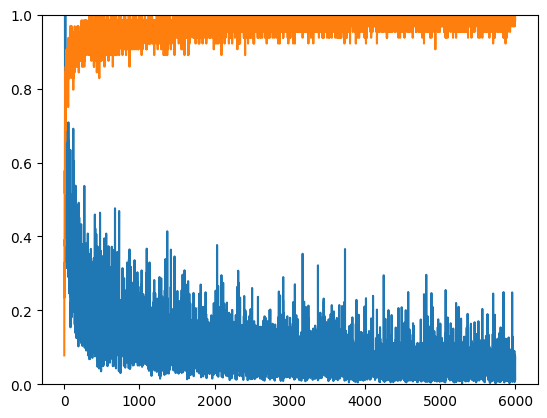

In [5]:
from maxine.optim import SDG

EPOCH = 6000
bs = 64 # increasing bs results in overfitting

losses, accuracies = [], []
t = tqdm.trange(EPOCH)

model2 = maxinet(p=0.2)
optim = SDG(model2.parameters(), 0.001)
loss_func = N.CrossEntropyLoss()

for i in t:
    samp = np.random.randint(0, x.shape[0], size=bs)
    X = x[samp]
    Y = y[samp]
    model2.do.train()
    model2.zero_grad()
    out = model2.forward(X)
    cat = torch.argmax(out, dim=-1)
    acc = (cat == Y).float().mean()
    loss = loss_func(out, Y)
    loss = loss.mean()
    loss.backward()
    optim.step()
    loss, acc = loss.item(), acc.item()
    losses.append(loss); accuracies.append(acc)
    t.set_description(f'loss: {losses[-1]:.2f} accuracy: {accuracies[-1]:.2f}')

plt.ylim(0, 1)
plt.plot(losses)
plt.plot(accuracies)

In [6]:
XV = dls.X_valid.reshape(10000, -1)
YV = dls.Y_valid

with torch.no_grad():
    xv = torch.tensor(XV).float()
    yv = torch.tensor(YV).long()
    out = model2.forward(xv, eval=True)
    cat = torch.argmax(out, dim=-1)
    print(yv[-10:]) # label
    print(cat[-10:]) # preds
    vacs = (cat == yv).float().mean()
    print(f"{vacs.item() * 100:.2f}" + "%")

tensor([9, 1, 5, 6, 5, 3, 2, 2, 5, 4])
tensor([9, 1, 5, 6, 5, 3, 2, 2, 5, 4])
98.05%



- 97% (p=0.4)
- bs = 64
- Epoch = 3000


1m -- CPU
- 98% (p=0.2)
- bs = 64
- Epoch = 6000

-----------------------------

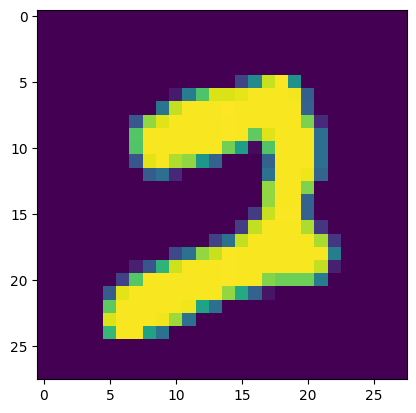

In [7]:
plt.imshow(x[0].reshape((28, 28))) # image

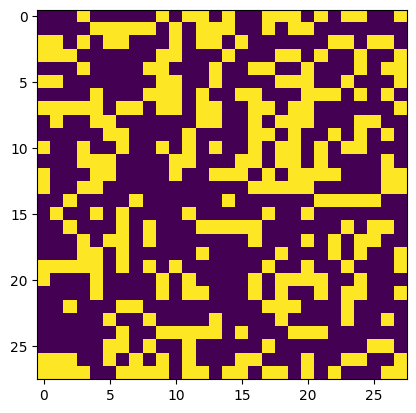

In [8]:
p = 0.4
mask = x.new(*x.shape).bernoulli_(p)
plt.imshow(mask[0].reshape((28, 28)))

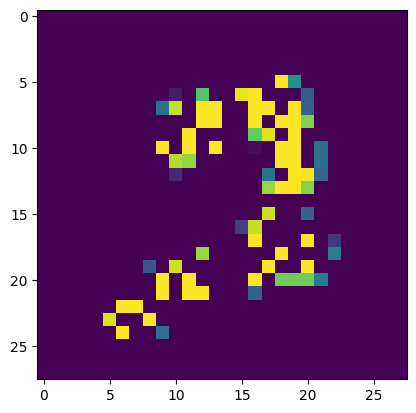

In [9]:
xd = mask * x
plt.imshow(xd[0].reshape((28, 28)))

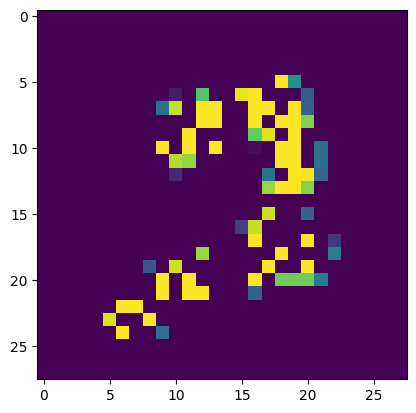

In [10]:
xd = (mask.div_(1-p)) * x 
# this division is explained in this blog: https://akash5100.github.io/blog/2024/02/07/LSTM.html
plt.imshow(xd[0].reshape((28, 28)))

In [11]:
# maxine dropout has issue with backprop